In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
sns.set()

from IPython.display import Markdown

In [ ]:
TITLE_SIZE = 18

#seeding
rng = np.random.default_rng(42)

In [84]:
#@title Default title text
# n = number of jobs
# μ = mean_service_rate
def run_MG1_sim_and_plot(n, small_mean_service_rate, large_mean_service_rate):

    #contains all E[T] from the simulation
    sim_mean_response_times = [None] * 9

    #contains all lamdas derived from the simulation
    sim_mean_arrival_rates = [None] * 9

    #contains all theoretical E[T]
    th_mean_response_times = [None] * 9

    #contains all theoretical lamdas
    th_mean_arrival_rates = [None] * 9

    #runs the simulation 9 times with utilization equal to 0.1, 0.2, ... , 0.9
    for i in range(1,10):
        lamda = (i/10)/(0.98*(1/small_mean_service_rate) + 0.02*(1/large_mean_service_rate))

        #returns a dictionary with: number of jobs, μ, λ, 1/λ, 1/μ
        params = build_MG1_params(n, lamda, small_mean_service_rate, large_mean_service_rate)
        #prints the params dictionary using Markdown
       # display(Markdown(
      #      f"### Simulation: n={n}, " +
      #      f"$\lambda$={format(params['mean_arrival_rate'])}, " +
      #      f"$\mu$={format(params['mean_service_rate'])}, " +
      #      f"$1/\lambda$={format(params['mean_interarrival_time'])}, " +
      #      f"$1/\mu$={format(params['mean_service_time'])}"
      #  ))
        #returns simulation params such as the E[T] and the calculated lamda
        result = run_MG1_sim(params)

        sim_mean_response_times[i-1] = result["response_time_mean"]
        sim_mean_arrival_rates[i-1] = result["mean_arrival_rate"]

        #E[s]
        th_mean_service_time = 0.98*params["small_mean_service_time"] + 0.02*params["large_mean_service_time"]

        #E[s^2]
        th_var_service_time = 0.98*pow(params["small_mean_service_time"], 2) + 0.02*pow(params["large_mean_service_time"],2)

        #Ε[Τ] = E[S] + lamda*E[s^2]/(2*(1-ρ))
        th_mean_response_times[i-1] = th_mean_service_time + (lamda*th_var_service_time)/(2*(1-(i/10)))
        th_mean_arrival_rates[i-1] = lamda

        dump_stats(result)
    #plots E[T] as a function of lamda for theoretical and simulated M/M/1's
    plot_MG1_response_per_lamda(sim_mean_response_times, sim_mean_arrival_rates, th_mean_response_times, th_mean_arrival_rates)

#builds the param dictionary
def build_MG1_params(num_jobs, mean_arrival_rate, small_mean_service_rate, large_mean_service_rate):
    return {
        "n": num_jobs,
        "mean_arrival_rate": mean_arrival_rate,
        "small_mean_service_rate": small_mean_service_rate,
        "large_mean_service_rate": large_mean_service_rate,
        "mean_interarrival_time": 1.0 / mean_arrival_rate,
        "small_mean_service_time": 1.0 / small_mean_service_rate,
        "large_mean_service_time": 1.0 / large_mean_service_rate,
    }

#generates the jobs and their respective arrival, wait, service times using mean_interarrival_time and μ
def run_MG1_sim(params):
    #num of jobs
    n = params["n"]

    #service times of jobs
    service_times = np.zeros(n)
    priority = np.zeros(n)

    # Parameters
    mean_interarrival_time = params["mean_interarrival_time"]
    small_mean_service_time = params["small_mean_service_time"]
    large_mean_service_time = params["large_mean_service_time"]

    # Simulation data and results
    #generating interarrival times using exponential distribution (scale = 1/λ , where λ the rate of the exponential)
    interarrival_times = rng.exponential(scale=mean_interarrival_time, size=n)
    #arrival time of each job is the sum of all the previous interarrival times plus it's own interarrival time
    arrival_times = np.cumsum(interarrival_times)

    for i in range(n):
        p = randint(1,100)
        if (p>98):
            #service time for large jobs, μ = 1/201
            service_times[i] = rng.exponential(scale=large_mean_service_time)
            priority[i] = 2
        else:
            #service time for small jobs μ=1/1
            service_times[i] = rng.exponential(scale=small_mean_service_time)
            priority[i] = 1

    #now that we know when every job arrives and how much service time it needs we can find when they exit the queue "start_time"
    #and when they get serviced and exit the system "departure time"
    jobs_df = build_SJF_jobs_df(params, interarrival_times, arrival_times, service_times, priority)
    #total time (secs) needed to service all jobs
    total_width = get_total_width(jobs_df)

    sim_mean_interarrival_time = jobs_df["interarrival_time"].mean()
    sim_mean_arrival_rate = 1.0 / sim_mean_interarrival_time
    sim_mean_service_time = jobs_df["service_time"].mean()
    sim_mean_service_rate = 1.0 / sim_mean_service_time
    sim_mean_wait_time = jobs_df["wait_time"].mean()
    sim_response_time_mean = jobs_df["response_time"].mean()
    sim_response_time_var = jobs_df["response_time"].var()

    # utilization
    util = estimate_util(jobs_df)

    return {
        "params": params,
        "jobs_df": jobs_df,
        "total_duration": total_width,
        "mean_arrival_rate": sim_mean_arrival_rate,
        "mean_interarrival_time": sim_mean_interarrival_time,
        "mean_service_rate": sim_mean_service_rate,
        "mean_service_time": sim_mean_service_time,
        "mean_wait_time": sim_mean_wait_time,
        "response_time_mean": sim_response_time_mean,
        "utilization": util,
    }


def build_SJF_jobs_df(params, interarrival_times, arrival_times, service_times, priority):
    n = params["n"]

    #jobs dataframe
    jobs_df = pd.DataFrame({
        "interarrival_time": interarrival_times,
        "arrive_time": arrival_times,
        "service_time": service_times,
        "start_time": np.zeros(n),
        "depart_time": np.zeros(n)
    })

    #first job gets serviced upon it's arrival time
    jobs_df.loc[0, "start_time"] = jobs_df.loc[0, "arrive_time"]
    #departs after it get's serviced
    jobs_df.loc[0, "depart_time"] = jobs_df.loc[0, "start_time"] + jobs_df.loc[0, "service_time"]
    #in_server = 0


    queue = []
    in_server = 0
    busy = False
    while(True):
        # if we have empty server then the next job tha arrives will be serviced
        if (busy == False and len(queue)==0):
            # we have to check if we are in the last loop and we need to exit
            if(in_server<n-1):
                in_server = in_server+1
                jobs_df.loc[in_server, "start_time"] = jobs_df.loc[in_server, "arrive_time"]
                jobs_df.loc[in_server, "depart_time"] = jobs_df.loc[in_server, "start_time"] + jobs_df.loc[in_server, "service_time"]
                busy = True
            else:
                break
        # if the server is empty but we have jobs at the queue we want to service the first in queue
        elif (busy == False and len(queue)!=0):
            # shortest will be defined below
            jobs_df.loc[shortest, "start_time"] = jobs_df.loc[in_server, "depart_time"]
            jobs_df.loc[shortest, "depart_time"] = jobs_df.loc[shortest, "start_time"] + jobs_df.loc[shortest, "service_time"]
            busy = True
            # now server is busy with the shortest so we se i as shortest
            in_server = shortest
            # we have to remove shortest from queue
            to_pop = queue.index(shortest)
            queue.pop(to_pop)
        else:
            busy = False
            # when server is busy we want to check all the jobs that arrived
            if (in_server<n-1):
                # the first job we want to check is the next one
                j = in_server + 1
                while( jobs_df.loc[j,"arrive_time"] < jobs_df.loc[in_server, "depart_time"]):
                    # we need an extra check to see if the jobs that will arrive is not already in queue
                    # or not already serviced (we check the jobs -- seiriaka --)
                    if(jobs_df.loc[j, "depart_time"] == 0 and j not in queue):
                        queue.append(j)
                    # a check to be sure that we are not at the last job -> check if we need to exit
                    if (j<n-1):
                        j+=1
                    else:
                        break
            # we need to find the shortest job in the queue
            min_service_time = 1000000
            shortest = j
            for k in queue:
                if(jobs_df.loc[k, "service_time"] < min_service_time ):
                    min_service_time = jobs_df.loc[k, "service_time"]
                    shortest = k

    #response time for each job is equal to queueing time plus service time or the time from when it arrives to the system
    #until it gets serviced
    jobs_df["response_time"] = jobs_df["depart_time"] - jobs_df["arrive_time"]
    jobs_df["wait_time"] = jobs_df["start_time"] - jobs_df["arrive_time"]

    return jobs_df



#total time system is active is equal to the time that last job finishes minus the arrival time of the 1st job in the system
def get_total_width(jobs_df):
    return jobs_df.iloc[-1]["depart_time"] - jobs_df.iloc[0]["arrive_time"]

#calculates utilization of the system: time the system services jobs / total simulation time
def estimate_util(jobs_df):
    busy = (jobs_df["depart_time"] - jobs_df["start_time"]).sum()
    return busy / get_total_width(jobs_df)

In [ ]:
# STATS DUMPS

def format(value):
    return f"{value:,.4f}"

#prints usefull information
def dump_stats(result):
    params = result["params"]
    jobs_df = result["jobs_df"]
    response_time = jobs_df["response_time"]
    arrival_rate_mean = result["mean_arrival_rate"]
    service_rate_mean = result["mean_service_rate"]
    service_time_mean = result["mean_service_time"]
    response_time_mean = result["response_time_mean"]
    util = result["utilization"]

    print("Simulation statistics")
    print("---------------------")
    print("total_duration          = " + format(result['total_duration']))
    print("arrival_rate_mean       = " + format(arrival_rate_mean))
    print("interarrival_time_mean  = " + format(result['mean_interarrival_time']))
    # Note: E[response_time] = E[wait_time] + E[service_time]
    print("response_time")
    print("  mean                  = " + format(response_time_mean))
    print("wait_time_mean          = " + format(result['mean_wait_time']))
    print("service_rate_mean       = " + format(service_rate_mean))
    print("service_time_mean       = " + format(service_time_mean))
    print("utilization             = " + format(util))

In [ ]:
# PLOTTING FUNCTIONS
#plots E[T] as a function of lamda for Theoretical and Simulation Values
def plot_MG1_response_per_lamda(sim_mean_response_times, sim_mean_arrival_rates, th_mean_response_times, th_mean_arrival_rates):


    plt.figure(figsize=(14, 2))
    plt.title("E[T] per Lamda", size=TITLE_SIZE)
    plt.xlabel("lamda")
    plt.ylabel("E[T]")
    plt.plot(th_mean_arrival_rates, th_mean_response_times, label="Theoretical", color="red")
    plt.plot(sim_mean_arrival_rates, sim_mean_response_times, label="Simulation", color="blue")
    plt.legend()
    plt.show()

Simulation statistics
---------------------
total_duration          = 49,078.0857
arrival_rate_mean       = 0.0204
interarrival_time_mean  = 49.0815
response_time
  mean                  = 20.3698
wait_time_mean          = 12.9752
service_rate_mean       = 0.1352
service_time_mean       = 7.3946
utilization             = 0.1507
Simulation statistics
---------------------
total_duration          = 24,254.4035
arrival_rate_mean       = 0.0412
interarrival_time_mean  = 24.2656
response_time
  mean                  = 17.2627
wait_time_mean          = 13.6662
service_rate_mean       = 0.2780
service_time_mean       = 3.5965
utilization             = 0.1483
Simulation statistics
---------------------
total_duration          = 16,663.6707
arrival_rate_mean       = 0.0600
interarrival_time_mean  = 16.6786
response_time
  mean                  = 26.6317
wait_time_mean          = 21.9477
service_rate_mean       = 0.2135
service_time_mean       = 4.6840
utilization             = 0.2811
Simulation

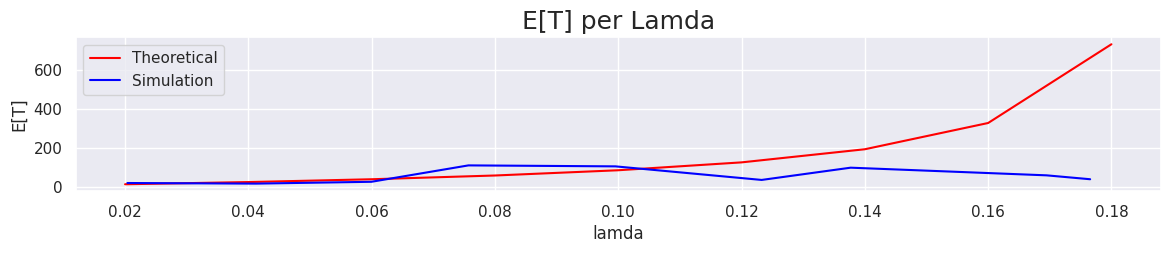

In [83]:
#M/G/1 : 98% service time = 1 sec, 2% service time = 201 secs
run_MG1_sim_and_plot(10000, 1, 1/201)